## Lab4: Introduction to Convolutional Layers

The goal of this lab is to understand how to train a convolutional neural network using PyTorch. A lot of starter code will be given to you, and the student is expected to build the network details. The network should be customizable for convolutional layers of different filter sizes, kernel sizes, strides, padding and pooling layers.

The dataset we will analyze will be a small section of the nih chest xrays dataset, found here: https://www.kaggle.com/nih-chest-xrays/sample . Please create a Kaggle account to download the data (or access in a class folder if we can get server use set up). The dataset has images of resolution 1024x1024, but to make it computationally easier we have first applied pooling in scipy to reduce the dimensionality to 64x64.

The task at hand is to treat the dataset as a multiclass classification problem with image inputs. We propose to build a model that is a series of spatial convolutional layers, activation functions, and pooling layers.

Before we get into the code, lets think for a bit about model selection. What are the necessary choices?

Number of hidden layers?

For each layer:

    Number of filters?

    Size of kernel?

    Size of padding? (maybe (kernel - 1) / 2)
    
    Stride of layer?
    
    Activation after layer:
    
        Some type of relu, tanh, sigmoid?
        
        Maybe add Batch normalization before the activation function?
    
    Maybe a pooling layer instead of a convolutional layer to decrease spatial dimension?

    Learning Rate?

    Momentum parameters for optimizers such as ADAM?

Other training techniques such as adding noise to input or hidden layers?

Image specific techniques such as random rotations or blurring of the image?

Other optional enhancements:

    Let us know if you have any ideas, there are approximately infinite different enhancements that can be included to help these types of models learn
    
Before you start to write code, try to have a choice of these hyperparameters in mind so you can try to implement them

In [1]:
#Import common dependencies
import torch
import pandas as pd, numpy as np, matplotlib, matplotlib.pyplot as plt
import datetime
import PIL, glob
import pickle
from pathlib import Path
from torch import nn
from torch.nn import init
from torch.autograd import Variable
from scipy import misc

## Dataset Selection

### First, read in the sample labels which we will treat as y classes, and split into trn and val

In [2]:
label_df = pd.read_csv('sample_labels.csv').iloc[:, :2]
label_df.index = label_df.iloc[:,0]
label_df = label_df.iloc[:,[1]]
label_df.columns = ['label']
num_rows = label_df.shape[0]
cutoff = .9
samples = np.random.rand(num_rows) < cutoff
trn, val = np.nonzero(samples)[0], np.nonzero(samples==0)[0]

### Next, map labels to unique values, and drop all uncommon labels into a 'unknown' label

In [3]:


uni_lbls = label_df['label'].value_counts().sort_values(ascending=False)
lbls = uni_lbls[uni_lbls > 10]
lbl_keys = lbls.keys()
num_keys = len(lbl_keys)
lbl_idx = np.arange(num_keys)

unk = 'unknown/uncommon'

lbl_map = {key:idx for key, idx in zip(lbl_keys, lbl_idx)}
inv_lbl_map = {idx:key for key, idx in zip(lbl_keys, lbl_idx)}

for lbl in label_df['label'].unique():
    if lbl not in lbl_map.keys():
        lbl_map[lbl] = num_keys
label_df['label_idx'] = label_df['label'].map(lbl_map)



### Load in the corresponding images, or load in the pre processed numpy array that we use to store them. Lets normalize them to [0,1]

In [4]:
my_file = Path("images.pickle")
if not my_file.is_file():
    import skimage.measure

    images = np.empty((num_rows, 64, 64))
    for idx,filename in enumerate(glob.glob('images/*')): #assuming gif
        im=misc.imread(filename)
        if im.shape[-1] < 5:
            im = im[:,:,0]
        im = skimage.measure.block_reduce(im, (16,16), np.max)
        images[idx,:,:] = im

    images = np.reshape(images, [num_rows, 1, 64, 64])
    images = images - images.min()
    images = images/images.max()
    pickle.dump(images, open('images.pickle', 'wb'))
else:
    images = pickle.load(open('images.pickle','rb'))

### Lets just visualize an image to see what we're looking at

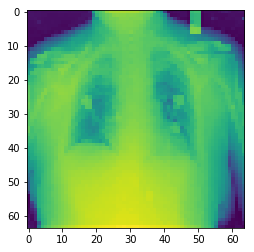

In [5]:
plt.imshow(images[0,0,:,:])
plt.show()

In [6]:
# Code to cleanly swap between Pytorch and Numpy.
# Makes PyTorch much more user friendly, but not widely used. 
# Base code from Andy Gan (Github BarclayII) with some minor additions

#Main adjustable flag. Enables or Disable GPU optimizations
USE_CUDA = 0

def cuda(obj):
    if USE_CUDA:
        if isinstance(obj, tuple):
            return tuple(cuda(o) for o in obj)
        elif isinstance(obj, list):
            return list(cuda(o) for o in obj)
        elif hasattr(obj, 'cuda'):
            return obj.cuda()
    return obj

def tovar(*arrs, **kwargs):
    tensors = [(torch.from_numpy(a) if isinstance(a, np.ndarray) else a) for a in arrs]
    vars_ = [torch.autograd.Variable(t, **kwargs) for t in tensors]
    if USE_CUDA:
        vars_ = [v.cuda() for v in vars_]
    return vars_[0] if len(vars_) == 1 else vars_


def tonumpy(*vars_):
    arrs = [(v.data.cpu().numpy() if isinstance(v, torch.autograd.Variable) else
             v.cpu().numpy() if torch.is_tensor(v) else v) for v in vars_]
    return arrs[0] if len(arrs) == 1 else arrs

### Before we build our network in Pytorch, lets look at the functions we're interested in using:

In [7]:
help(nn.LeakyReLU)

Help on class LeakyReLU in module torch.nn.modules.activation:

class LeakyReLU(torch.nn.modules.module.Module)
 |  Applies element-wise,
 |  :math:`f(x) = max(0, x) + {negative\_slope} * min(0, x)`
 |  
 |  Args:
 |      negative_slope: Controls the angle of the negative slope. Default: 1e-2
 |      inplace: can optionally do the operation in-place. Default: ``False``
 |  
 |  Shape:
 |      - Input: :math:`(N, *)` where `*` means, any number of additional
 |        dimensions
 |      - Output: :math:`(N, *)`, same shape as the input
 |  
 |  Examples::
 |  
 |      >>> m = nn.LeakyReLU(0.1)
 |      >>> input = autograd.Variable(torch.randn(2))
 |      >>> print(input)
 |      >>> print(m(input))
 |  
 |  Method resolution order:
 |      LeakyReLU
 |      torch.nn.modules.module.Module
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, negative_slope=0.01, inplace=False)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __repr_

In [8]:
help(nn.MaxPool2d)

Help on class MaxPool2d in module torch.nn.modules.pooling:

class MaxPool2d(torch.nn.modules.module.Module)
 |  Applies a 2D max pooling over an input signal composed of several input
 |  planes.
 |  
 |  In the simplest case, the output value of the layer with input size :math:`(N, C, H, W)`,
 |  output :math:`(N, C, H_{out}, W_{out})` and :attr:`kernel_size` :math:`(kH, kW)`
 |  can be precisely described as:
 |  
 |  .. math::
 |  
 |      \begin{array}{ll}
 |      out(N_i, C_j, h, w)  = \max_{{m}=0}^{kH-1} \max_{{n}=0}^{kW-1}
 |                             input(N_i, C_j, stride[0] * h + m, stride[1] * w + n)
 |      \end{array}
 |  
 |  | If :attr:`padding` is non-zero, then the input is implicitly zero-padded on both sides
 |    for :attr:`padding` number of points
 |  | :attr:`dilation` controls the spacing between the kernel points. It is harder to describe,
 |    but this `link`_ has a nice visualization of what :attr:`dilation` does.
 |  
 |  The parameters :attr:`kernel_siz

In [9]:
help(nn.Conv2d)

Help on class Conv2d in module torch.nn.modules.conv:

class Conv2d(_ConvNd)
 |  Applies a 2D convolution over an input signal composed of several input
 |  planes.
 |  
 |  In the simplest case, the output value of the layer with input size
 |  :math:`(N, C_{in}, H, W)` and output :math:`(N, C_{out}, H_{out}, W_{out})`
 |  can be precisely described as:
 |  
 |  .. math::
 |  
 |      \begin{array}{ll}
 |      out(N_i, C_{out_j})  = bias(C_{out_j})
 |                     + \sum_{{k}=0}^{C_{in}-1} weight(C_{out_j}, k)  \star input(N_i, k)
 |      \end{array}
 |  
 |  where :math:`\star` is the valid 2D `cross-correlation`_ operator,
 |  :math:`N` is a batch size, :math:`C` denotes a number of channels,
 |  :math:`H` is a height of input planes in pixels, and :math:`W` is
 |  width in pixels.
 |  
 |  | :attr:`stride` controls the stride for the cross-correlation, a single
 |    number or a tuple.
 |  | :attr:`padding` controls the amount of implicit zero-paddings on both
 |  |  sides f

In [10]:
#Build the network in pytorch

def init_weights(module):
    #Optional: Initialize weights using Xavier Initialization 
    for name, param in module.named_parameters():
        if name.find('weight') != -1:
            if len(param.size()) == 1:
                init.uniform(param.data, 1)
            else:
                init.xavier_uniform(param.data)
        elif name.find('bias') != -1:
            init.constant(param.data, 0)

class Identity(nn.Module):
    #Identity Module
    def __init__(self):
        nn.Module.__init__(self)

    def forward(self, x):
        return x

class Model(nn.Module):
    def __init__(self,input_shape, hidden_layers, num_outputs, lr = 1e-3):
        #num_inputs is the number of input feature
        #Hidden layers is a list of hidden layer sizes)
        nn.Module.__init__(self)
        self.input_shape = input_shape
        
        prev_filters = 1
        self.hidden_layers = nn.ModuleList()
        shape = input_shape
        self.trn_losses = []
        self.val_losses = []
        #TODO
        #Create a reference to an activation function
        self.relu = #
        if 1:
            for idx, (filters, kernel_size, stride, padding, pool) in enumerate(hidden_layers):
                if pool:
                    #TODO
                    #Build a nn.MaxPool2d layer
                    layer = #
                    self.hidden_layers.append(layer)
                else:
                    #TODO
                    #Build a nn.Conv2d layer
                    layer = #
                    self.hidden_layers.append(layer)
                    self.hidden_layers.append(self.relu)
                    prev_filters = filters
                if idx == 0:
                    self.first_layer = layer
                shape = shape // stride
            self.flat_size = prev_filters * shape * shape
            #TODO
            # Create a linear output layer with num_outputs outputs
            self.output_layer = #
        else:
            #Optionally: Design your custom network without programmatic interface here!
            pass
        
        self.loss_fcn = nn.CrossEntropyLoss()
            
        self.optimizer = torch.optim.RMSprop(self.parameters(), lr = lr, weight_decay = 1e-8)
        init_weights(self)
        print(self.hidden_layers)
        
    def forward(self, x, y):

        x = tovar(x).float()
        for layer in self.hidden_layers:
            x = layer(x)
        x = x.view(-1, self.flat_size)
        output = self.output_layer(x)
        return output, self.loss_fcn(output, y)


In [11]:

def train(epochs = 3, verbosity = 0, val_freq = 1):
    num_epochs = epochs
    bs = 128
    rows_trn = len(trn)
    batches_per_epoch = rows_trn // bs
    for epoch in range(num_epochs):
        # Optimize Model on mini batches
        trn_loss = []
        trn_acc = [0,0]
        order = np.arange(rows_trn)
        np.random.shuffle(order)
        for itr in range(batches_per_epoch):
            rows = order[itr*bs:(itr+1)*bs]
            if itr+1 == batches_per_epoch:
                rows = order[itr*bs:]
            samples = trn[rows]
            x, y = images[samples,:,:,:], label_df.iloc[samples, 1].as_matrix()

            y_pred, loss = model(x, tovar(y))

            # Before the backward pass, use the optimizer object to zero all of the 
            # gradients for the variables it will update (which are the learnable weights of the model)
            model.optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # Calling the step function on an Optimizer makes an update to its parameters
            model.optimizer.step()
            trn_loss.append(tonumpy(loss.data[0]))
            if itr % 100 == 0:
                print('itr:', itr)
        if epoch % val_freq == 0:
            #Evaluate Performance on on validation set
            trn_loss = np.mean(trn_loss)
            model.trn_losses.append(trn_loss)
            samples = val
            xval, yval = images[samples,:,:,:], label_df.iloc[samples, 1].as_matrix()
            y_pred, loss = model(xval, tovar(yval))
            val_loss = tonumpy(loss.data[0])
            print( 'epoch:', epoch)
            print('train loss: ',trn_loss)
            print('val loss: ',val_loss)
            trn_loss = []
            model.val_losses.append(val_loss)
def visualize(verbosity = 0):
    #Visualize performance of training and validation throughout training
    print('Best Loss:', min(model.val_losses))
    plt.close()     
    plt.plot(model.trn_losses, label='train loss')
    plt.plot(model.val_losses, label='val loss')
    plt.legend()
    plt.title('losses')
    plt.show()

Now the code is done so lets test our model with different parameter settings!

In [12]:
num_epochs = 6
verb = 0
#As in model, hidden layers have order (filters, kernel_size, stride, padding, pool)
#filters is the number of filters in the layer,
#the layer has kernels of shape kernel_size x kernel_size,
#stride is the stride length in each direction
#padding is the padding width in each direction. consider (kernel_size -1)/2
#pool is an indicator for pooling. 0 for convolution, 1 for pooling.

#filters, kernel_size, stride, padding, pool
hidden_layers = [
    [32, 5, 2, 2, 0],
    [16, 3, 2, 1, 0],
    [16, 3, 1, 1, 0],
    [0,  3, 2, 1, 1],
    [16, 3, 1, 1, 0],
    [0,  3, 2, 1, 1],
    [16, 3, 1, 1, 0],
]

ModuleList(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): LeakyReLU(0.01)
  (2): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): LeakyReLU(0.01)
  (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): LeakyReLU(0.01)
  (6): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (7): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): LeakyReLU(0.01)
  (9): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (10): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): LeakyReLU(0.01)
)
itr: 0
epoch: 0
train loss:  2.23209680349
val loss:  2.098757266998291
itr: 0
epoch: 1
train loss:  2.04022148328
val loss:  2.099350690841675
itr: 0
epoch: 2
train loss:  2.03707215419
val loss:  2.0992319583892822
itr: 0
epoch: 3
train loss:  2.0343537942
val loss:  2.169424295425415
itr: 0
epoch:

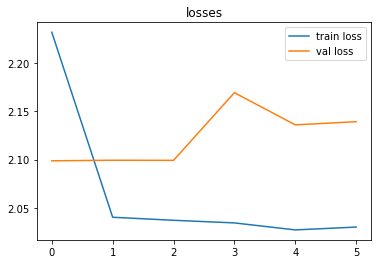

In [13]:

model = cuda(Model(images.shape[2], hidden_layers = hidden_layers, num_outputs= int(num_keys + 1)))
x = train(epochs = num_epochs, verbosity = verb)
visualize()

## Now lets visualize the types of features the early layers of the model has learned

In [14]:
weights = tonumpy(model.first_layer.weight.data)

In [15]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None) or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [16]:
#Code adapted from https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1
def show_images(images, rows = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    rows
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None) or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(rows, np.ceil(n_images/float(rows)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

## With a normal ML dataset we should see more reasonable learned features, I don't see the model learning much with our tiny training efforts though.

In [17]:
show_images([weight[0] for weight in weights], rows = 4)